In [1]:
# NPG, TRPO, ACER, PPO, ACKTR

In [2]:
import gym
import torch
import random
import numpy as np
from scipy.stats import uniform, argus, alpha, beta, rv_continuous, rv_discrete
from sklearn.model_selection import RandomizedSearchCV

from gym import Wrapper

from tqdm import tqdm_notebook as tqdm
from collections import defaultdict

from itertools import count
import matplotlib.pyplot as plt

In [3]:
def c_softmax(x, sf=1, mag=2, shift=1):
    return 1/(1 + np.exp(-x * sf)) * mag - shift
def p_tanh(x, power=3, expl=0.001, mag=1, shift=0):
    return np.tanh(np.power(x, power) * expl) * mag - shift
def t_power(x, power=2, expl=0.5, mag=2, shift=1):
    return np.tanh(np.sign(x) * np.power(x, power) * expl) * mag - shift

In [4]:
class BaseAgent():
    def _set_seed(self, seed, env):
        env.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    def _extract_x(self, X):
        seed,  environments = X[0]
        environments = {
            env.env.unwrapped.__class__.__name__:{'env':env} for env in environments
        }
        return seed, environments

    def fit(self, X):
        seed, environments = self._extract_x(X)
        self.results = {}
        for env_name, env_data in environments.items():
            env = env_data['env'].env
            gamma = env_data['env'].gamma
            max_episodes = env_data['env'].max_episodes
            goal_mean_reward = env_data['env'].goal_mean_reward
            self._set_seed(seed, env)
            print('Training on {} environment with seed {} and params {}'.format(env_name, seed, self.params))
            self.results[env_name] = self.train(env, gamma, max_episodes, goal_mean_reward)
        return self.results

    def score(self, X):
        seed, environments = self._extract_x(X)
        total_score = 0
        for env_name, env_data in environments.items():
            env = env_data['env'].env
            self._set_seed(seed, env)
            
            policy = self.results[env_name]['policy']
            e_mean_reward = self.evaluate(env, policy)
            t_episodes = self.results[env_name]['training_episodes']
            t_episodes_weight = env_data['env'].training_episodes_weight
            t_mean_reward = self.results[env_name]['training_mean_reward']
            t_mean_reward_weight = env_data['env'].training_mean_reward_weight
            e_mean_reward_weight = env_data['env'].evaluation_mean_reward_weight
            goal_mean_reward = env_data['env'].goal_mean_reward

            e_mean_reward_score = c_softmax(e_mean_reward / goal_mean_reward - 1, 50)
            w_e_mean_reward_score = e_mean_reward_score * e_mean_reward_weight
            
            t_mean_reward_bonus = c_softmax(t_mean_reward / goal_mean_reward - 1, 50)
            w_t_mean_reward_bonus = t_mean_reward_bonus * t_mean_reward_weight
            
            t_episodes_bonus = t_power(env_data['env'].max_episodes/t_episodes - 1)
            w_t_episodes_bonus = t_episodes_bonus * t_episodes_weight
            
            score = w_e_mean_reward_score + w_t_episodes_bonus + w_t_mean_reward_bonus

            print("Score in the {} environment with seed {}:"
                  "\nAgent = {}"
                  "\nScore = {}. Breakdown:"
                  "\n\tEvaluation mean reward = {}, normalized = {}, weighted = {}"
                  "\n\tTraining mean reward = {}, normalized = {}, weighted = {}"
                  "\n\tTraining episodes = {}, normalized = {}, weighted = {}"
                  "".format(env_name, seed, 
                            self,
                            score,
                            e_mean_reward, e_mean_reward_score, w_e_mean_reward_score,
                            t_mean_reward, t_mean_reward_bonus, w_t_mean_reward_bonus,
                            t_episodes, t_episodes_bonus, w_t_episodes_bonus))
            total_score += score

        print('Total score across all environments for seed {} = {}'.format(seed, total_score))
        print('---------------------------------------------\n')
        return total_score
    
    def demo(self, environment, results):
        self.evaluate(env=environment.env, episodes=1, 
                      policy=results[environment.get_environment_name()]['policy'], 
                      render=True)
        
    def get_params(self, deep=False):
        return self.params

    def set_params(self, **params):
        self.params = {
            k:v for k, v in params.items()
        }
        for k, v in self.params.items():
            setattr(self, k, v)
        return self

    def __repr__(self):
        class_name = self.__class__.__name__
        params_str = ', '.join([str(k) + '=' + str(v) for k, v in self.params.items()])
        return '%s(%s)' % (class_name, params_str)

In [5]:
class Qlearning(BaseAgent):
    def __init__(self):
        self.params = {}
        self.results = {}
        
    def train(self, env, gamma, max_episodes, goal_mean_reward):
        nS, nA = env.observation_space.n, env.action_space.n
        Q = np.zeros((nS, nA))

        rewards = []
        with tqdm(total=max_episodes) as pbar:
            for e in range(max_episodes):
                state, done = env.reset(), False
                self.behavioral_strategy.reset()
                rewards.append(0)
                while not done:
                    action = self.behavioral_strategy.select_action(Q[state])
                    new_state, reward, done, _ = env.step(action)
                    rewards[-1] += reward
                    target = reward + (not done) * gamma * Q[new_state].max()
                    error = target - Q[state][action]
                    Q[state][action] += self.alpha() * error
                    state = new_state

                V = np.max(Q, axis=1)
                policy = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
                if e % (max_episodes/100) == 0:
                    training_mean_reward = self.evaluate(env, policy)
                    if training_mean_reward >= goal_mean_reward:
                        pbar.update(pbar.total - e)
                        break
                pbar.update(1)
        results = {
            'Q': Q,
            'V': V,
            'policy': policy,
            'training_episodes': e+1,
            'training_mean_reward': training_mean_reward,
        }
        return results

    def evaluate(self, env, policy, episodes=100, render=False):
        rewards = []
        for e in range(episodes):
            state, is_terminal = env.reset(), False
            rewards.append(0)
            for t in count(start=1):
                if render: env.render()
                action = policy[state]
                state, reward, is_terminal, _ = env.step(action)
                rewards[-1] += reward
                if is_terminal:
                    break

        if render: env.render()
        env.close()
        return np.mean(rewards)

In [6]:
class BaseSchedule():
    def __init__(self, *args, **kwds):
        self.params = kwds
        for k, v in self.params.items():
            setattr(self, k, v)
        self.reset()
    def __call__(self):
        raise NotImplemented
    def reset(self):
        setattr(self, '_t', 0)
    @property
    def tick(self):
        curr_t = self._t
        self._t += 1
        return curr_t
    def __repr__(self):
        class_name = self.__class__.__name__
        self.params['value'] = self.value
        params_str = ', '.join(['{}={}'.format(k, round(v, 3)) for k, v in self.params.items()])
        return "{}({})".format(class_name, params_str)

In [7]:
class ConstantSchedule(BaseSchedule):
    def __call__(self):
        self.tick
        return self.value

In [8]:
class LinearlyDecayingSchedule(BaseSchedule):
    def __call__(self):
        self.value = max(self.min_value, self.initial_value - (1 - self.decay_rate) * self.tick)
        return self.value
    def reset(self):
        super(LinearlyDecayingSchedule, self).reset()
        self.value = self.initial_value

In [9]:
class ExponentiallyDecayingSchedule(BaseSchedule):
    def __call__(self):
        self.value = max(self.min_value, self.initial_value * np.exp((self.decay_rate - 1) * self.tick))
        return self.value
    def reset(self):
        super(ExponentiallyDecayingSchedule, self).reset()
        self.value = self.initial_value

0 0.45180440585549864 ConstantSchedule(value=0.452)
1 0.45180440585549864 ConstantSchedule(value=0.452)
2 0.45180440585549864 ConstantSchedule(value=0.452)
0 ConstantSchedule(value=0.452)
ConstantSchedule(value=0.452)
0.45180440585549864 0.45180440585549864 0.45180440585549864


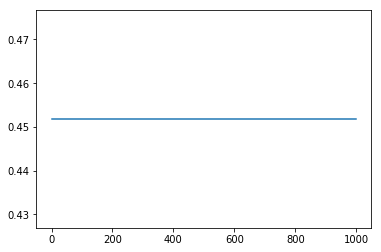

In [10]:
s = ConstantSchedule(value=uniform().rvs())
for i in range(np.random.randint(10)):
    print(s._t, s(), s)
s.reset()
print(s._t, s)
x, y = [], []
for i in range(1000):
    x.append(i)
    y.append(s())
print(s)
print(np.min(y), np.mean(y), np.max(y))
plt.plot(x, y)
plt.show()

0 1.0 LinearlyDecayingSchedule(initial_value=1.0, min_value=0.01, decay_rate=0.99, value=1.0)
0 LinearlyDecayingSchedule(initial_value=1.0, min_value=0.01, decay_rate=0.99, value=1.0)
LinearlyDecayingSchedule(initial_value=1.0, min_value=0.01, decay_rate=0.99, value=0.01)
0.01 0.05949999999999995 1.0


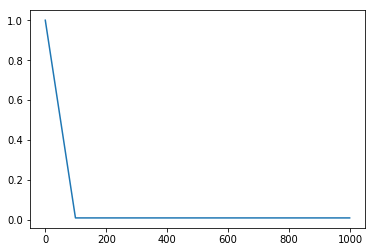

In [11]:
s = LinearlyDecayingSchedule(initial_value=1.0, min_value=0.01, decay_rate=0.99)
for i in range(np.random.randint(10)):
    print(s._t, s(), s)
s.reset()
print(s._t, s)
x, y = [], []
for i in range(1000):
    x.append(i)
    y.append(s())
print(s)
print(np.min(y), np.mean(y), np.max(y))
plt.plot(x, y)
plt.show()

0 1.0 ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.01, decay_rate=0.99, value=1.0)
1 0.990049833749168 ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.01, decay_rate=0.99, value=0.99)
2 0.9801986733067553 ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.01, decay_rate=0.99, value=0.98)
3 0.9704455335485082 ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.01, decay_rate=0.99, value=0.97)
4 0.9607894391523232 ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.01, decay_rate=0.99, value=0.961)
0 ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.01, decay_rate=0.99, value=1.0)
ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.01, decay_rate=0.99, value=0.01)
0.01 0.10489066729883752 1.0


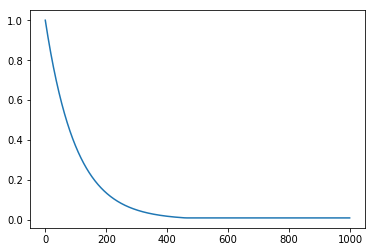

In [12]:
s = ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.01, decay_rate=0.99)
for i in range(np.random.randint(10)):
    print(s._t, s(), s)
s.reset()
print(s._t, s)
x, y = [], []
for i in range(1000):
    x.append(i)
    y.append(s())
print(s)
print(np.min(y), np.mean(y), np.max(y))
plt.plot(x, y)
plt.show()

In [13]:
class EpsilonGreedyPolicy():
    def __init__(self, epsilon_schedule):
        self.epsilon_schedule = epsilon_schedule
        self.epsilon = self.epsilon_schedule()
    def reset(self):
        self.epsilon_schedule.reset()
    def select_action(self, Qs):
        action = np.argmax(Qs) if np.random.random() > self.epsilon else np.random.randint(len(Qs))
        self.epsilon = self.epsilon_schedule()
        return action
    def __repr__(self):
        class_name = self.__class__.__name__
        return "{}(epsilon={}, {})".format(class_name, self.epsilon, self.epsilon_schedule)

In [14]:
s = EpsilonGreedyPolicy(
    epsilon_schedule=ExponentiallyDecayingSchedule(
        initial_value=0.9, 
        min_value=0.1, 
        decay_rate=uniform().rvs()))
s

EpsilonGreedyPolicy(epsilon=0.9, ExponentiallyDecayingSchedule(initial_value=0.9, min_value=0.1, decay_rate=0.398, value=0.9))

0.7451733400516704 0.9579710233314589 0.999679129131949


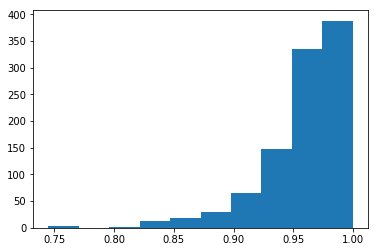

In [15]:
lot = [argus(6).rvs() for _ in range(1000)]
print(np.min(lot), np.mean(lot), np.max(lot))
plt.hist(lot)
plt.show()

0.0001685830822697465 0.06486158574486038 0.4748855720195916


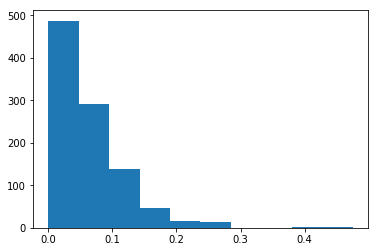

In [16]:
class argus_complement(rv_continuous):
    def __init__(self, *args, **kwargs):
        self.argus = argus(*args, **kwargs)
    def rvs(self, *args, **kwargs):
        argus_value = self.argus.rvs(*args, **kwargs) 
        return min(max(0.0, 1 - argus_value), 1.0)
lot = [argus_complement(5).rvs() for _ in range(1000)]
print(np.min(lot), np.mean(lot), np.max(lot))
plt.hist(lot)
plt.show()

0.044368217298718836 0.4969017113835828 0.9324051465157296


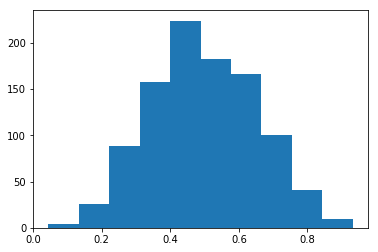

In [17]:
lot = [beta(5, 5).rvs() for _ in range(1000)]
print(np.min(lot), np.mean(lot), np.max(lot))
plt.hist(lot)
plt.show()

0.7849796848612132 0.968031297000859 0.9999958029617093


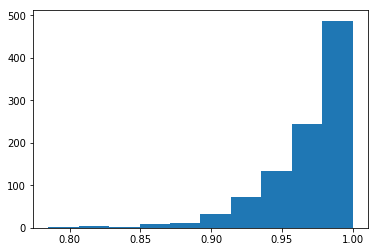

In [18]:
class beta_complement(rv_continuous):
    def __init__(self, *args, **kwargs):
        self.beta = beta(*args, **kwargs)
    def rvs(self, *args, **kwargs):
        beta_value = self.beta.rvs(*args, **kwargs) 
        return min(max(0, 1 - beta_value), 1.0)
lot = [beta_complement(1, 30).rvs() for _ in range(1000)]
print(np.min(lot), np.mean(lot), np.max(lot))
plt.hist(lot)
plt.show()

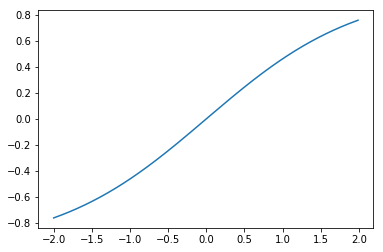

In [19]:
def c_softmax(x, sf=1, mag=2, shift=1):
    return 1/(1 + np.exp(-x * sf)) * mag - shift
x = np.arange(-2, 2, 0.01)
lot = [c_softmax(i, 1, 2, 1) for i in x]
plt.plot(x, lot)
plt.show()

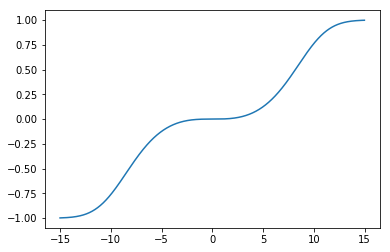

In [20]:
def p_tanh(x, power=3, expl=0.001, mag=1, shift=0):
    return np.tanh(np.power(x, power) * expl) * mag - shift
x = np.arange(-15, 15, 0.01)
lot = [p_tanh(i) for i in x]
plt.plot(x, lot)
plt.show()

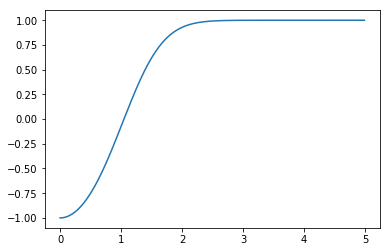

In [20]:
def t_power(x, power=2, expl=0.5, mag=2, shift=1):
    return np.tanh(np.sign(x) * np.power(x, power) * expl) * mag - shift
x = np.arange(0, 5, 0.01)
lot = [t_power(i, power=2, expl=0.5) for i in x]
plt.plot(x, lot)
plt.show()

In [21]:
class TrainingConfiguration:
    def __init__(self, seeds, environments):
        self.seeds = seeds
        self.environments = environments
    def data(self):
        return [(seed, self.environments) for seed in self.seeds]

In [22]:
class TrainingEnvironment:
    def __init__(self, 
                 env, 
                 gamma,
                 max_episodes, 
                 goal_mean_reward,
                 training_mean_reward_weight,
                 training_episodes_weight,
                 evaluation_mean_reward_weight):
        self.env = env
        self.gamma = gamma
        self.max_episodes = max_episodes
        self.goal_mean_reward = goal_mean_reward
        self.training_mean_reward_weight = training_mean_reward_weight
        self.training_episodes_weight = training_episodes_weight
        self.evaluation_mean_reward_weight = evaluation_mean_reward_weight
    def get_environment_name(self):
        return self.env.unwrapped.__class__.__name__

In [23]:
seeds = (
    12,
    34,
    56,
    78,
    90,
)

environments = (
    TrainingEnvironment(
        env=gym.make('FrozenLake-v0'), 
        gamma=0.99,
        max_episodes=5000,
        goal_mean_reward=0.70,
        training_mean_reward_weight=0.1,
        training_episodes_weight=0.2,
        evaluation_mean_reward_weight=0.7,
    ),
    #TrainingEnvironment(
    #    env=gym.make('Taxi-v2'), 
    #    max_episodes=100000,
    #    goal_mean_reward=800,
    #    training_mean_reward_weight=0.03,
    #    training_episodes_weight=0.07,
    #    evaluation_mean_reward_weight=0.9,
    #),
)

training_configuration = TrainingConfiguration(seeds=seeds, environments=environments)

In [24]:
class ParamGrid():
    def __init__(self):
        self.grid = {}
    def add(self, param, func, times=5):
        if param not in self.grid:
            self.grid[param] = []
        self.grid[param] += [func() for _ in range(times)]
    def data(self):
        return self.grid
    def __len__(self):
        count = 0
        for k, v in self.grid.items():
            count += len(v)
        return count

In [25]:
grid = ParamGrid()
grid.add(
    'alpha', 
    lambda: ConstantSchedule(
        value=beta(5, 5).rvs()
    )
)
grid.add(
    'alpha', 
    lambda: LinearlyDecayingSchedule(
        initial_value=1.0, 
        min_value=beta(10, 80).rvs(), 
        decay_rate=beta(50, 0.6).rvs()
    )
)
grid.add(
    'alpha', 
    lambda: ExponentiallyDecayingSchedule(
        initial_value=1.0, 
        min_value=beta(10, 80).rvs(), 
        decay_rate=beta(50, 0.6).rvs()
    )
)
grid.add(
    'behavioral_strategy', 
    lambda: EpsilonGreedyPolicy(
        epsilon_schedule=ConstantSchedule(
            value=beta(5, 50).rvs()
        )
    )
)
grid.add(
    'behavioral_strategy', 
    lambda: EpsilonGreedyPolicy(
        epsilon_schedule=LinearlyDecayingSchedule(
            initial_value=1.0, 
            min_value=beta(1, 100).rvs(),
            decay_rate=beta(50, 0.6).rvs()
        )
    )
)
grid.add(
    'behavioral_strategy', 
    lambda: EpsilonGreedyPolicy(
        epsilon_schedule=ExponentiallyDecayingSchedule(
            initial_value=1.0, 
            min_value=beta(1, 100).rvs(),
            decay_rate=beta(50, 0.6).rvs()
        )
    )
)
grid.data()

{'alpha': [ConstantSchedule(value=0.603),
  ConstantSchedule(value=0.723),
  ConstantSchedule(value=0.744),
  ConstantSchedule(value=0.341),
  ConstantSchedule(value=0.393),
  LinearlyDecayingSchedule(initial_value=1.0, min_value=0.098, decay_rate=1.0, value=1.0),
  LinearlyDecayingSchedule(initial_value=1.0, min_value=0.168, decay_rate=0.99, value=1.0),
  LinearlyDecayingSchedule(initial_value=1.0, min_value=0.137, decay_rate=0.998, value=1.0),
  LinearlyDecayingSchedule(initial_value=1.0, min_value=0.071, decay_rate=0.958, value=1.0),
  LinearlyDecayingSchedule(initial_value=1.0, min_value=0.052, decay_rate=0.976, value=1.0),
  ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.06, decay_rate=0.994, value=1.0),
  ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=1.0),
  ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.111, decay_rate=0.998, value=1.0),
  ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.09, deca

In [26]:
class OneToOneCV:
    def get_n_splits(self, X=None, y=None, groups=None):
        return len(X)
    def split(self, X, y=None, groups=None):
        for i in range(len(X)):
            yield [np.array([i]), np.array([i])]

In [27]:
agent = Qlearning()
rsearch = RandomizedSearchCV(estimator=agent, 
                             param_distributions=grid.data(), 
                             n_iter=len(grid),
                             cv=OneToOneCV(), 
                             refit=False,
                             iid=False,
                             return_train_score=False,
                             n_jobs=-1,
                             verbose=0)
rsearch.fit(training_configuration.data())

Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=1.0)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_value=0.168, decay_rate=0.99, value=1.0)}
Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=1.0)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_value=0.168, decay_rate=0.99, value=1.0)}
Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=1.0)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_value=0.168, decay_rate=0.99, value=1.0)}
Training on FrozenLakeEnv environment with seed 56 and params {'behavi

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.09, decay_rate=0.996, value=1.0)}
Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.09, decay_rate=0.996, value=1.0)}
Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.09891688511742908, ConstantSchedule(value=0.099)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=1.0)}
Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': Ep


Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9628540027476498, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=0.963)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.168, decay_rate=0.99, value=0.168))
Score = -0.4657152780942059. Breakdown:
	Evaluation mean reward = 0.54, normalized = -0.9999782399563084, weighted = -0.6999847679694159
	Training mean reward = 0.71, normalized = 0.3426949069654588, weighted = 0.03426949069654588
	Training episodes = 901, normalized = 0.9999999958933206, weighted = 0.19999999917866412
Total score across all environments for seed 12 = -0.4657152780942059
---------------------------------------------

Training on FrozenLakeEnv environment with seed 56 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.09891688511742908, ConstantSchedule(value=0.099)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_v



Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.950472003663533, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=0.95)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.168, decay_rate=0.99, value=0.168))
Score = 0.9939580773746546. Breakdown:
	Evaluation mean reward = 0.78, normalized = 0.9934246772281319, weighted = 0.6953972740596923
	Training mean reward = 0.77, normalized = 0.9866142981514305, weighted = 0.09866142981514306
	Training episodes = 1251, normalized = 0.9994968674990963, weighted = 0.19989937349981926
Total score across all environments for seed 90 = 0.9939580773746546
---------------------------------------------

Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.09891688511742908, ConstantSchedule(value=0.099)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value

Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9876180009158833, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=0.988)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.168, decay_rate=0.99, value=0.168))
Score = -0.4622155317827092. Breakdown:
	Evaluation mean reward = 0.62, normalized = -0.993424677228132, weighted = -0.6953972740596923
	Training mean reward = 0.71, normalized = 0.3426949069654588, weighted = 0.03426949069654588
	Training episodes = 1401, normalized = 0.9945612579021861, weighted = 0.19891225158043724
Total score across all environments for seed 78 = -0.4622155317827092
---------------------------------------------

Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.98, value=1.0)), 'alpha': LinearlyDeca


Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9996391736340207, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.071, decay_rate=0.958, value=0.071))
Score = 0.8057841581332867. Breakdown:
	Evaluation mean reward = 0.74, normalized = 0.8913734677347187, weighted = 0.623961427414303
	Training mean reward = 0.7, normalized = 0.0, weighted = 0.0
	Training episodes = 1701, normalized = 0.9091136535949187, weighted = 0.18182273071898375
Total score across all environments for seed 56 = 0.8057841581332867
---------------------------------------------

Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.98, value=1.0)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_va


Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.8142700137382488, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=0.814)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.168, decay_rate=0.99, value=0.168))
Score = 0.8871530078838054. Breakdown:
	Evaluation mean reward = 0.77, normalized = 0.9866142981514305, weighted = 0.6906300087060013
	Training mean reward = 0.7, normalized = 0.0, weighted = 0.0
	Training episodes = 1501, normalized = 0.98261499588902, weighted = 0.19652299917780403
Total score across all environments for seed 56 = 0.8871530078838054
---------------------------------------------

Training on FrozenLakeEnv environment with seed 56 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.98, value=1.0)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_



Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9998797245446736, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.071, decay_rate=0.958, value=0.071))
Score = -0.5170859994475904. Breakdown:
	Evaluation mean reward = 0.61, normalized = -0.9967756945029475, weighted = -0.6977429861520632
	Training mean reward = 0.77, normalized = 0.9866142981514305, weighted = 0.09866142981514306
	Training episodes = 2151, normalized = 0.40997778444664923, weighted = 0.08199555688932986
Total score across all environments for seed 90 = -0.5170859994475904
---------------------------------------------

Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.98, value=1.0)), 'alpha': LinearlyDec



Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9624131553491263, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=0.962)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.09, decay_rate=0.996, value=0.09))
Score = 0.9356106243511527. Breakdown:
	Evaluation mean reward = 0.8, normalized = 0.9984202681165271, weighted = 0.6988941876815689
	Training mean reward = 0.74, normalized = 0.8913734677347187, weighted = 0.08913734677347188
	Training episodes = 1901, normalized = 0.7378954494805599, weighted = 0.147579089896112
Total score across all environments for seed 56 = 0.9356106243511527
---------------------------------------------

Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=1.0)), 'alpha': E

Training on FrozenLakeEnv environment with seed 56 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=1.0)}
Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9133260064111828, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=0.913)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.168, decay_rate=0.99, value=0.168))
Score = 0.8313093749539672. Breakdown:
	Evaluation mean reward = 0.76, normalized = 0.9728461661125116, weighted = 0.6809923162787581
	Training mean reward = 0.76, normalized = 0.9728461661125116, weighted = 0.09728461661125117
	Training episodes = 2251, normalized = 0.26516221031978904, weighted = 0.05303244206395781


Total score across all environments for seed 34 = 0.8313093749539672
---------------------------------------------

Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=1.0)}



Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.11386286623716069, ConstantSchedule(value=0.114)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.052, decay_rate=0.976, value=0.052))
Score = 0.7897058130144037. Breakdown:
	Evaluation mean reward = 0.79, normalized = 0.9967756945029476, weighted = 0.6977429861520632
	Training mean reward = 0.75, normalized = 0.9453064264076343, weighted = 0.09453064264076344
	Training episodes = 2451, normalized = -0.01283907889211533, weighted = -0.0025678157784230662
Total score across all environments for seed 56 = 0.7897058130144037
---------------------------------------------



Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=1.0)}



Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9309825943595155, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=0.931)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=0.073))
Score = 0.9130987741877749. Breakdown:
	Evaluation mean reward = 0.74, normalized = 0.8913734677347187, weighted = 0.623961427414303
	Training mean reward = 0.74, normalized = 0.8913734677347187, weighted = 0.08913734677347188
	Training episodes = 251, normalized = 1.0, weighted = 0.2
Total score across all environments for seed 34 = 0.9130987741877749
---------------------------------------------

Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), 'alpha': ConstantSchedule(value=0.723)}



Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9185558675613521, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.98, value=0.919)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.052, decay_rate=0.976, value=0.052))
Score = -0.33492470714101163. Breakdown:
	Evaluation mean reward = 0.66, normalized = -0.8913734677347183, weighted = -0.6239614274143027
	Training mean reward = 0.74, normalized = 0.8913734677347187, weighted = 0.08913734677347188
	Training episodes = 1251, normalized = 0.9994968674990963, weighted = 0.19989937349981926
Total score across all environments for seed 56 = -0.33492470714101163
---------------------------------------------

Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), 'alpha': ConstantSchedule(value=0.723)}



Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9974491625889466, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=0.997)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.09, decay_rate=0.996, value=0.09))
Score = -0.7783863334298268. Breakdown:
	Evaluation mean reward = 0.55, normalized = -0.9999555506739739, weighted = -0.6999688854717817
	Training mean reward = 0.71, normalized = 0.3426949069654588, weighted = 0.03426949069654588
	Training episodes = 3001, normalized = -0.5634346932729546, weighted = -0.11268693865459092
Total score across all environments for seed 90 = -0.7783863334298268
---------------------------------------------

Training on FrozenLakeEnv environment with seed 56 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), 'alpha': ConstantSchedule(value=0.723)}



Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9389169006710141, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.98, value=0.939)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.052, decay_rate=0.976, value=0.052))
Score = 0.8857766829397844. Breakdown:
	Evaluation mean reward = 0.74, normalized = 0.8913734677347187, weighted = 0.623961427414303
	Training mean reward = 0.75, normalized = 0.9453064264076343, weighted = 0.09453064264076344
	Training episodes = 1801, normalized = 0.8364230644235897, weighted = 0.16728461288471796
Total score across all environments for seed 34 = 0.8857766829397844
---------------------------------------------

Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), 'alpha': ConstantSchedule(value=0.723)}




Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.11386286623716069, ConstantSchedule(value=0.114)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.052, decay_rate=0.976, value=0.052))
Score = -0.7250694842246463. Breakdown:
	Evaluation mean reward = 0.65, normalized = -0.9453064264076338, weighted = -0.6617144984853437
	Training mean reward = 0.71, normalized = 0.3426949069654588, weighted = 0.03426949069654588
	Training episodes = 2901, normalized = -0.4881223821792423, weighted = -0.09762447643584847
Total score across all environments for seed 12 = -0.7250694842246463
---------------------------------------------

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), 'alpha': ConstantSchedule(value=0.723)}
Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behaviora



Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.979638966890338, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.98, value=0.98)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.052, decay_rate=0.976, value=0.052))
Score = 0.497776687747657. Breakdown:
	Evaluation mean reward = 0.71, normalized = 0.3426949069654588, weighted = 0.23988643487582115
	Training mean reward = 0.8, normalized = 0.9984202681165271, weighted = 0.09984202681165272
	Training episodes = 1851, normalized = 0.7902411303009154, weighted = 0.1580482260601831
Total score across all environments for seed 78 = 0.497776687747657
---------------------------------------------

Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.007, decay_rate=0.998, value=1.0)), 'alpha': LinearlyDecayingS

Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9995188981786942, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.071, decay_rate=0.958, value=0.071))
Score = 0.46389490567386904. Breakdown:
	Evaluation mean reward = 0.73, normalized = 0.7899988299594711, weighted = 0.5529991809716297
	Training mean reward = 0.81, normalized = 0.999226343498715, weighted = 0.0999226343498715
	Training episodes = 4051, normalized = -0.9451345482381608, weighted = -0.18902690964763216
Total score across all environments for seed 78 = 0.46389490567386904
---------------------------------------------

Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.007, decay_rate=0.998, value=1.0)), 'alpha': LinearlyDecayin


Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9232512448220334, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.007, decay_rate=0.998, value=0.923)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.098, decay_rate=1.0, value=0.098))
Score = 0.9964044159672062. Breakdown:
	Evaluation mean reward = 0.79, normalized = 0.9967756945029476, weighted = 0.6977429861520632
	Training mean reward = 0.77, normalized = 0.9866142981514305, weighted = 0.09866142981514306
	Training episodes = 301, normalized = 1.0, weighted = 0.2
Total score across all environments for seed 56 = 0.9964044159672062
---------------------------------------------

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.007, decay_rate=0.998, value=1.0)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, mi

Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9898356246362454, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=0.99)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=0.073))
Score = -0.2726850300498239. Breakdown:
	Evaluation mean reward = 0.68, normalized = -0.613357260395381, weighted = -0.42935008227676663
	Training mean reward = 0.74, normalized = 0.8913734677347187, weighted = 0.08913734677347188
	Training episodes = 2201, normalized = 0.3376385272673543, weighted = 0.06752770545347087
Total score across all environments for seed 12 = -0.2726850300498239
---------------------------------------------

Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.028, decay_rate=0.993, value=1.0)), 'alpha': 


Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9949048319493907, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=0.995)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=0.073))
Score = 0.4008818747610981. Breakdown:
	Evaluation mean reward = 0.71, normalized = 0.3426949069654588, weighted = 0.23988643487582115
	Training mean reward = 0.73, normalized = 0.7899988299594711, weighted = 0.07899988299594712
	Training episodes = 2151, normalized = 0.40997778444664923, weighted = 0.08199555688932986
Total score across all environments for seed 78 = 0.4008818747610981
---------------------------------------------

Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.028, decay_rate=0.993, value=1.0)), 'alpha': 



Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.8574727682323662, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.98, value=0.857)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.052, decay_rate=0.976, value=0.052))
Score = -0.6318620984448858. Breakdown:
	Evaluation mean reward = 0.63, normalized = -0.9866142981514303, weighted = -0.6906300087060012
	Training mean reward = 0.72, normalized = 0.6133572603953845, weighted = 0.061335726039538456
	Training episodes = 2451, normalized = -0.01283907889211533, weighted = -0.0025678157784230662
Total score across all environments for seed 90 = -0.6318620984448858
---------------------------------------------

Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9673419250195006, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997,


Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.11536442599539684, ConstantSchedule(value=0.115)), alpha=ConstantSchedule(value=0.723))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 34 = -0.9999999999999999
---------------------------------------------

Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.028, decay_rate=0.993, value=1.0)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_value=0.052, decay_rate=0.976, value=1.0)}

Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.11386286



Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0620865541722682, ConstantSchedule(value=0.062)), alpha=ConstantSchedule(value=0.341))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 78 = -0.9999999999999999
---------------------------------------------

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.028, decay_rate=0.993, value=1.0)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_value=0.052, decay_rate=0.976, value=1.0)}
Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.994904831


Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.999, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=1.0)}



Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.11386286623716069, ConstantSchedule(value=0.114)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.052, decay_rate=0.976, value=0.052))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2


Total score across all environments for seed 34 = -0.9999999999999999
---------------------------------------------

Training on FrozenLakeEnv environment with seed 56 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.999, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=1.0)}

Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.11536442599539684, ConstantSchedule(value=0.115)), alpha=ConstantSchedule(value=0.723))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 90 = -0.9999999999999999
---------------------------------------------

Tra

Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0620865541722682, ConstantSchedule(value=0.062)), alpha=ConstantSchedule(value=0.341))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 34 = -0.9999999999999999
---------------------------------------------

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.999, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=1.0)}
Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0

Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.11536442599539684, ConstantSchedule(value=0.115)), alpha=ConstantSchedule(value=0.723))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 78 = -0.9999999999999999
---------------------------------------------

Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), 'alpha': ConstantSchedule(value=0.744)}




Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.11386286623716069, ConstantSchedule(value=0.114)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.052, decay_rate=0.976, value=0.052))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 78 = -0.9999999999999999
---------------------------------------------

Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9856096084041313, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.007, decay_rate=0.998, value=0.986)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.098, decay_rate=1.0, value=0.098))
Score = 0.5385477709947993. Breakdown:
	Evaluati


Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0620865541722682, ConstantSchedule(value=0.062)), alpha=ConstantSchedule(value=0.341))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 56 = -0.9999999999999999
---------------------------------------------

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), 'alpha': ConstantSchedule(value=0.744)}




Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9880080070034427, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.007, decay_rate=0.998, value=0.988)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.098, decay_rate=1.0, value=0.098))
Score = 0.9002437887446174. Breakdown:
	Evaluation mean reward = 0.74, normalized = 0.8913734677347187, weighted = 0.623961427414303
	Training mean reward = 0.74, normalized = 0.8913734677347187, weighted = 0.08913734677347188
	Training episodes = 1651, normalized = 0.9357250727842126, weighted = 0.18714501455684251

Total score across all environments for seed 34 = 0.9002437887446174
---------------------------------------------

Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.0620865541722682, ConstantSchedule(value=0.062)), 'alpha': ConstantSchedule(value=0.744)}
Score in the FrozenLakeEnv 


Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.09891688511742908, ConstantSchedule(value=0.099)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=0.074))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.06, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.08, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 56 = -0.9999999999999999
---------------------------------------------

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.0620865541722682, ConstantSchedule(value=0.062)), 'alpha': ConstantSchedule(value=0.744)}



Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), alpha=ConstantSchedule(value=0.723))
Score = 0.6992769056671188. Breakdown:
	Evaluation mean reward = 0.77, normalized = 0.9866142981514305, weighted = 0.6906300087060013
	Training mean reward = 0.74, normalized = 0.8913734677347187, weighted = 0.08913734677347188
	Training episodes = 2801, normalized = -0.4024522490617721, weighted = -0.08049044981235443
Total score across all environments for seed 78 = 0.6992769056671188
---------------------------------------------

Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=1.0)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_value=0.137, decay_rate=0.998, value=1.0)}



Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9671008414870099, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.028, decay_rate=0.993, value=0.967)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.06, decay_rate=0.994, value=0.06))
Score = 0.8797827204649604. Breakdown:
	Evaluation mean reward = 0.77, normalized = 0.9866142981514305, weighted = 0.6906300087060013
	Training mean reward = 0.73, normalized = 0.7899988299594711, weighted = 0.07899988299594712
	Training episodes = 2051, normalized = 0.5507641438150594, weighted = 0.1101528287630119
Total score across all environments for seed 56 = 0.8797827204649604
---------------------------------------------

Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=1.0)), 'alpha': Linear


Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.09891688511742908, ConstantSchedule(value=0.099)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=0.074))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 78 = -0.9999999999999999
---------------------------------------------

Training on FrozenLakeEnv environment with seed 56 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=1.0)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_value=0.137, decay_rate=0.998, value=1.0)}



Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.09891688511742908, ConstantSchedule(value=0.099)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=0.074))
Score = -0.7656797816031096. Breakdown:
	Evaluation mean reward = 0.65, normalized = -0.9453064264076338, weighted = -0.6617144984853437
	Training mean reward = 0.75, normalized = 0.9453064264076343, weighted = 0.09453064264076344
	Training episodes = 4601, normalized = -0.9924796287926463, weighted = -0.19849592575852926
Total score across all environments for seed 90 = -0.7656797816031096
---------------------------------------------

Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=1.0)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_value=0.1


Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9098263111295232, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=0.91)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.137, decay_rate=0.998, value=0.137))
Score = 0.823961427414303. Breakdown:
	Evaluation mean reward = 0.74, normalized = 0.8913734677347187, weighted = 0.623961427414303
	Training mean reward = 0.7, normalized = 0.0, weighted = 0.0
	Training episodes = 651, normalized = 1.0, weighted = 0.2
Total score across all environments for seed 34 = 0.823961427414303
---------------------------------------------

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=1.0)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_value=0.137, decay_rat

Total score across all environments for seed 78 = -0.5777378700161397
---------------------------------------------

Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=1.0)), 'alpha': ConstantSchedule(value=0.723)}
Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.980260504892206, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.028, decay_rate=0.993, value=0.98)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.06, decay_rate=0.994, value=0.06))
Score = -0.7276695778008191. Breakdown:
	Evaluation mean reward = 0.55, normalized = -0.9999555506739739, weighted = -0.6999688854717817
	Training mean reward = 0.7, normalized = 0.0, weighted = 0.0
	Training episodes = 2551, normalized = -0.13850346164518668, weighted = -0.027700692329037338
Total

Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9915046831234728, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.999, value=0.992)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=0.073))
Score = -0.07889099499054586. Breakdown:
	Evaluation mean reward = 0.69, normalized = -0.34269490696546123, weighted = -0.23988643487582284
	Training mean reward = 0.73, normalized = 0.7899988299594711, weighted = 0.07899988299594712
	Training episodes = 2151, normalized = 0.40997778444664923, weighted = 0.08199555688932986
Total score across all environments for seed 90 = -0.07889099499054586


---------------------------------------------

Training on FrozenLakeEnv environment with seed 56 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=1.0)), 'alpha': ConstantSchedule(value=0.723)}




Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.993420168297402, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.028, decay_rate=0.993, value=0.993)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.06, decay_rate=0.994, value=0.06))
Score = -0.7467484866747448. Breakdown:
	Evaluation mean reward = 0.62, normalized = -0.993424677228132, weighted = -0.6953972740596923
	Training mean reward = 0.72, normalized = 0.6133572603953845, weighted = 0.061335726039538456
	Training episodes = 3001, normalized = -0.5634346932729546, weighted = -0.11268693865459092
Total score across all environments for seed 78 = -0.7467484866747448
---------------------------------------------


Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=1.0)), 'alpha': Co


Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), alpha=ConstantSchedule(value=0.723))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 12 = -0.9999999999999999
---------------------------------------------

Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.023, decay_rate=0.993, value=1.0)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_value=0.137, decay_rate=0.998, value=1.0)}



Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), alpha=ConstantSchedule(value=0.723))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 34 = -0.9999999999999999
---------------------------------------------

Training on FrozenLakeEnv environment with seed 56 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.023, decay_rate=0.993, value=1.0)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_value=0.137, decay_rate=0.998, value=1.0)}



Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.993420168297402, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.028, decay_rate=0.993, value=0.993)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.052, decay_rate=0.976, value=0.052))
Score = -0.7843741244737557. Breakdown:
	Evaluation mean reward = 0.56, normalized = -0.9999092042625951, weighted = -0.6999364429838165
	Training mean reward = 0.73, normalized = 0.7899988299594711, weighted = 0.07899988299594712
	Training episodes = 3501, normalized = -0.8171878224294309, weighted = -0.1634375644858862
Total score across all environments for seed 78 = -0.7843741244737557
---------------------------------------------

Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.023, decay_rate=0.993, value=1.0)), 'alpha': Lin


Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9671008414870099, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.028, decay_rate=0.993, value=0.967)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.052, decay_rate=0.976, value=0.052))
Score = -0.32766165497319394. Breakdown:
	Evaluation mean reward = 0.69, normalized = -0.34269490696546123, weighted = -0.23988643487582284
	Training mean reward = 0.73, normalized = 0.7899988299594711, weighted = 0.07899988299594712
	Training episodes = 3551, normalized = -0.8338755154665909, weighted = -0.1667751030933182
Total score across all environments for seed 90 = -0.32766165497319394
---------------------------------------------

Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=1.0)), 'alpha'



Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), alpha=ConstantSchedule(value=0.744))
Score = 0.15055910250693386. Breakdown:
	Evaluation mean reward = 0.71, normalized = 0.3426949069654588, weighted = 0.23988643487582115
	Training mean reward = 0.7, normalized = 0.0, weighted = 0.0
	Training episodes = 2851, normalized = -0.4466366618444364, weighted = -0.08932733236888729
Total score across all environments for seed 78 = 0.15055910250693386
---------------------------------------------

Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=1.0)), 'alpha': ConstantSchedule(value=0.723)}
Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.99744


Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), alpha=ConstantSchedule(value=0.723))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 90 = -0.9999999999999999
---------------------------------------------

Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=1.0)), 'alpha': ConstantSchedule(value=0.723)}

Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.980260504892206, LinearlyDecayingSchedule(initial_value=1.0, min



Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9546299190640855, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.023, decay_rate=0.993, value=0.955)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.137, decay_rate=0.998, value=0.137))
Score = 0.9320013463195634. Breakdown:
	Evaluation mean reward = 0.79, normalized = 0.9967756945029476, weighted = 0.6977429861520632
	Training mean reward = 0.71, normalized = 0.3426949069654588, weighted = 0.03426949069654588
	Training episodes = 1151, normalized = 0.999944347354772, weighted = 0.1999888694709544
Total score across all environments for seed 34 = 0.9320013463195634
---------------------------------------------

Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.98, value=1.0)), 'alpha': Exponenti

Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.900944007327066, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=0.901)), alpha=ConstantSchedule(value=0.723))
Score = 0.9164789849487043. Breakdown:
	Evaluation mean reward = 0.74, normalized = 0.8913734677347187, weighted = 0.623961427414303
	Training mean reward = 0.75, normalized = 0.9453064264076343, weighted = 0.09453064264076344
	Training episodes = 1451, normalized = 0.9899345744681884, weighted = 0.1979869148936377
Total score across all environments for seed 90 = 0.9164789849487043
---------------------------------------------

Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.98, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.


Total score across all environments for seed 34 = 0.48900198515424137
---------------------------------------------

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.98, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=1.0)}



Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.996215354221057, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.999, value=0.996)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=0.073))
Score = 0.2777120432886926. Breakdown:
	Evaluation mean reward = 0.72, normalized = 0.6133572603953845, weighted = 0.42935008227676913
	Training mean reward = 0.71, normalized = 0.3426949069654588, weighted = 0.03426949069654588
	Training episodes = 3951, normalized = -0.9295376484231119, weighted = -0.1859075296846224
Total score across all environments for seed 12 = 0.2777120432886926
---------------------------------------------

Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), 'alpha': Exp


Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0620865541722682, ConstantSchedule(value=0.062)), alpha=ConstantSchedule(value=0.744))
Score = -0.5552142792831369. Breakdown:
	Evaluation mean reward = 0.68, normalized = -0.613357260395381, weighted = -0.42935008227676663
	Training mean reward = 0.7, normalized = 0.0, weighted = 0.0
	Training episodes = 3101, normalized = -0.6293209850318515, weighted = -0.1258641970063703
Total score across all environments for seed 90 = -0.5552142792831369
---------------------------------------------


Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.09, decay_rate=0.996, value=1.0)}


Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9974491625889466, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=0.997)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.137, decay_rate=0.998, value=0.137))
Score = -0.7368101149414107. Breakdown:
	Evaluation mean reward = 0.54, normalized = -0.9999782399563084, weighted = -0.6999847679694159
	Training mean reward = 0.71, normalized = 0.3426949069654588, weighted = 0.03426949069654588
	Training episodes = 2751, normalized = -0.35547418834270317, weighted = -0.07109483766854063
Total score across all environments for seed 12 = -0.7368101149414107
---------------------------------------------

Training on FrozenLakeEnv environment with seed 56 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), 'alpha': Exp

Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9483187405383926, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.023, decay_rate=0.993, value=0.948)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.137, decay_rate=0.998, value=0.137))
Score = 0.6725085390352913. Breakdown:
	Evaluation mean reward = 0.72, normalized = 0.6133572603953845, weighted = 0.42935008227676913
	Training mean reward = 0.72, normalized = 0.6133572603953845, weighted = 0.061335726039538456
	Training episodes = 1701, normalized = 0.9091136535949187, weighted = 0.18182273071898375
Total score across all environments for seed 12 = 0.6725085390352913
---------------------------------------------

Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), 'alpha': Exponent


Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9752360018317665, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=0.975)), alpha=ConstantSchedule(value=0.723))
Score = 0.3296526498249479. Breakdown:
	Evaluation mean reward = 0.71, normalized = 0.3426949069654588, weighted = 0.23988643487582115
	Training mean reward = 0.73, normalized = 0.7899988299594711, weighted = 0.07899988299594712
	Training episodes = 2401, normalized = 0.0538316597658981, weighted = 0.01076633195317962
Total score across all environments for seed 12 = 0.3296526498249479
---------------------------------------------


Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_ra


Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9923669914836164, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=0.992)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.137, decay_rate=0.998, value=0.137))
Score = 0.8362151385443173. Breakdown:
	Evaluation mean reward = 0.8, normalized = 0.9984202681165271, weighted = 0.6988941876815689
	Training mean reward = 0.77, normalized = 0.9866142981514305, weighted = 0.09866142981514306
	Training episodes = 2301, normalized = 0.19329760523802686, weighted = 0.03865952104760537
Total score across all environments for seed 56 = 0.8362151385443173
---------------------------------------------

Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), 'alpha': Exponenti


Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.8874568572684327, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.023, decay_rate=0.993, value=0.887)), alpha=LinearlyDecayingSchedule(initial_value=1.0, min_value=0.137, decay_rate=0.998, value=0.137))
Score = 0.00859430572055813. Breakdown:
	Evaluation mean reward = 0.69, normalized = -0.34269490696546123, weighted = -0.23988643487582284
	Training mean reward = 0.72, normalized = 0.6133572603953845, weighted = 0.061335726039538456
	Training episodes = 1651, normalized = 0.9357250727842126, weighted = 0.18714501455684251
Total score across all environments for seed 90 = 0.00859430572055813
---------------------------------------------

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), 'alpha': Ex


Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), alpha=ConstantSchedule(value=0.744))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 12 = -0.9999999999999999
---------------------------------------------

Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_value=0.052, decay_rate=0.976, value=1.0)}

Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9546299190640855, ExponentiallyDecayingSchedule(initia




Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9992783472680413, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=0.999)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.09, decay_rate=0.996, value=0.09))
Score = 0.7238801336534844. Breakdown:
	Evaluation mean reward = 0.72, normalized = 0.6133572603953845, weighted = 0.42935008227676913
	Training mean reward = 0.75, normalized = 0.9453064264076343, weighted = 0.09453064264076344
	Training episodes = 1051, normalized = 0.9999970436797587, weighted = 0.19999940873595176
Total score across all environments for seed 12 = 0.7238801336534844
---------------------------------------------

Training on FrozenLakeEnv environment with seed 56 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), 'alpha': LinearlyDecayingSchedule(initial_value=1.0, min_value

Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), alpha=ConstantSchedule(value=0.744))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9858812711646208, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.999, value=0.986)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=0.073))
Score = -0.9999997291668844. Breakdown:
	Evaluation mean reward = 0.48, normalized = -0.9999997004961856, weighted = -0.6999997903473298
	Training mean reward = 0.49, normalized = -0.9999993881955461, weighted = -0.0999

Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9990524927507252, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.999, value=0.999)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=0.073))
Score = 0.3906300087543639. Breakdown:
	Evaluation mean reward = 0.77, normalized = 0.9866142981514305, weighted = 0.6906300087060013
	Training mean reward = 0.39, normalized = -0.9999999995163743, weighted = -0.09999999995163744
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 56 = 0.3906300087543639
---------------------------------------------

Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), 'alpha': ConstantSchedule(value=0.341)}



Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9992783472680413, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=0.999)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.09, decay_rate=0.996, value=0.09))
Score = 0.7872658100904776. Breakdown:
	Evaluation mean reward = 0.73, normalized = 0.7899988299594711, weighted = 0.5529991809716297
	Training mean reward = 0.71, normalized = 0.3426949069654588, weighted = 0.03426949069654588
	Training episodes = 1101, normalized = 0.9999856921115104, weighted = 0.1999971384223021
Total score across all environments for seed 78 = 0.7872658100904776
---------------------------------------------

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.0775019291289278, ConstantSchedule(value=0.078)), 'alpha': ConstantSchedule(value=0.341)}



Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.2670028080521689, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.98, value=0.267)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=0.074))
Score = 0.8429345761199813. Breakdown:
	Evaluation mean reward = 0.73, normalized = 0.7899988299594711, weighted = 0.5529991809716297
	Training mean reward = 0.77, normalized = 0.9866142981514305, weighted = 0.09866142981514306
	Training episodes = 1601, normalized = 0.9563698266660432, weighted = 0.19127396533320865
Total score across all environments for seed 78 = 0.8429345761199813
---------------------------------------------

Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), 'alpha': ConstantSc


Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9998797245446736, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=0.074))
Score = 0.9547208291936955. Breakdown:
	Evaluation mean reward = 0.75, normalized = 0.9453064264076343, weighted = 0.6617144984853439
	Training mean reward = 0.77, normalized = 0.9866142981514305, weighted = 0.09866142981514306
	Training episodes = 1551, normalized = 0.9717245044660427, weighted = 0.19434490089320855
Total score across all environments for seed 34 = 0.9547208291936955
---------------------------------------------

Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), 'alpha': ConstantSched


Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0620865541722682, ConstantSchedule(value=0.062)), alpha=ConstantSchedule(value=0.744))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 34 = -0.9999999999999999
---------------------------------------------

Training on FrozenLakeEnv environment with seed 56 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), 'alpha': ConstantSchedule(value=0.603)}

Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0620865541722682, ConstantSchedule(value=0.062)), alpha=ConstantSchedul

Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9995188981786942, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.09, decay_rate=0.996, value=0.09))
Score = -0.4451332947793161. Breakdown:
	Evaluation mean reward = 0.61, normalized = -0.9967756945029475, weighted = -0.6977429861520632
	Training mean reward = 0.72, normalized = 0.6133572603953845, weighted = 0.061335726039538456
	Training episodes = 1601, normalized = 0.9563698266660432, weighted = 0.19127396533320865
Total score across all environments for seed 90 = -0.4451332947793161
---------------------------------------------

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), 'alpha': ConstantSch


Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.0620865541722682, ConstantSchedule(value=0.062)), alpha=ConstantSchedule(value=0.744))
Score = -0.9999999999999999. Breakdown:
	Evaluation mean reward = 0.0, normalized = -1.0, weighted = -0.7
	Training mean reward = 0.0, normalized = -1.0, weighted = -0.1
	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 78 = -0.9999999999999999
---------------------------------------------

Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.999, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.09, decay_rate=0.996, value=1.0)}


Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0


Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9429479294766345, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=0.943)), alpha=ConstantSchedule(value=0.723))
Score = 0.6838881012421132. Breakdown:
	Evaluation mean reward = 0.77, normalized = 0.9866142981514305, weighted = 0.6906300087060013
	Training mean reward = 0.77, normalized = 0.9866142981514305, weighted = 0.09866142981514306
	Training episodes = 2951, normalized = -0.5270166863951559, weighted = -0.10540333727903117
Total score across all environments for seed 34 = 0.6838881012421132
---------------------------------------------

Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.999, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.0

Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9986769699914091, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=0.999)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=0.074))
Score = 0.8621185635085516. Breakdown:
	Evaluation mean reward = 0.77, normalized = 0.9866142981514305, weighted = 0.6906300087060013
	Training mean reward = 0.72, normalized = 0.6133572603953845, weighted = 0.061335726039538456
	Training episodes = 2051, normalized = 0.5507641438150594, weighted = 0.1101528287630119
Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9987972454467355, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=0.999)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.09, decay_rate=0.996, value=0.09))
Score = 0.833

Total score across all environments for seed 90 = -0.61752765193846
---------------------------------------------



Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.996, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=1.0)}
Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.8778338013420282, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.98, value=0.878)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=0.074))
Score = -0.5380895936626098. Breakdown:
	Evaluation mean reward = 0.66, normalized = -0.8913734677347183, weighted = -0.6239614274143027
	Training mean reward = 0.72, normalized = 0.6133572603953845, weighted = 0.061335726039538456
	Training episodes = 2351, normalized = 0.12268053856077255, weighted = 0.02453610771215451
Total score across



Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9990377963573884, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=0.999)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=0.074))
Score = -0.2973177572168617. Breakdown:
	Evaluation mean reward = 0.68, normalized = -0.613357260395381, weighted = -0.42935008227676663
	Training mean reward = 0.73, normalized = 0.7899988299594711, weighted = 0.07899988299594712
	Training episodes = 2251, normalized = 0.26516221031978904, weighted = 0.05303244206395781
Total score across all environments for seed 12 = -0.2973177572168617
---------------------------------------------

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.996, value=1.0)), 'alpha'

Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9995188981786942, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), alpha=ConstantSchedule(value=0.603))
Score = 0.8143349070111581. Breakdown:
	Evaluation mean reward = 0.73, normalized = 0.7899988299594711, weighted = 0.5529991809716297
	Training mean reward = 0.72, normalized = 0.6133572603953845, weighted = 0.061335726039538456
	Training episodes = 751, normalized = 0.9999999999999498, weighted = 0.19999999999998996
Total score across all environments for seed 34 = 0.8143349070111581
---------------------------------------------

Training on FrozenLakeEnv environment with seed 12 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.996, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_ra

Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9974491625889466, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=0.997)), alpha=ConstantSchedule(value=0.723))
Score = 0.6292508551642859. Breakdown:
	Evaluation mean reward = 0.75, normalized = 0.9453064264076343, weighted = 0.6617144984853439
	Training mean reward = 0.78, normalized = 0.9934246772281319, weighted = 0.09934246772281319
	Training episodes = 3151, normalized = -0.6590305552193557, weighted = -0.13180611104387116
Total score across all environments for seed 78 = 0.6292508551642859
---------------------------------------------

Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.996, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.07

Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9997594490893471, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=1.0)), alpha=ConstantSchedule(value=0.603))
Score = 0.9567330000983009. Breakdown:
	Evaluation mean reward = 0.78, normalized = 0.9934246772281319, weighted = 0.6953972740596923
	Training mean reward = 0.72, normalized = 0.6133572603953845, weighted = 0.061335726039538456
	Training episodes = 801, normalized = 0.9999999999953508, weighted = 0.19999999999907017
Total score across all environments for seed 56 = 0.9567330000983009
---------------------------------------------

Training on FrozenLakeEnv environment with seed 56 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.996, value=1.0)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_ra


Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9977147663487975, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=0.998)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=0.074))
Score = -0.5151953181675657. Breakdown:
	Evaluation mean reward = 0.53, normalized = -0.9999893474929373, weighted = -0.6999925432450561
	Training mean reward = 0.72, normalized = 0.6133572603953845, weighted = 0.061335726039538456
	Training episodes = 2001, normalized = 0.6173074951897601, weighted = 0.12346149903795203
Total score across all environments for seed 90 = -0.5151953181675657
---------------------------------------------

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=1.0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.996, value=1.0)), 'alpha':


Score in the FrozenLakeEnv environment with seed 78:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9991580718127149, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.012, decay_rate=1.0, value=0.999)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=0.074))
Score = 0.32176635945606485. Breakdown:
	Evaluation mean reward = 0.71, normalized = 0.3426949069654588, weighted = 0.23988643487582115
	Training mean reward = 0.76, normalized = 0.9728461661125116, weighted = 0.09728461661125117
	Training episodes = 2501, normalized = -0.07702346015503725, weighted = -0.015404692031007451
Total score across all environments for seed 78 = 0.32176635945606485
---------------------------------------------

Training on FrozenLakeEnv environment with seed 34 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.11536442599539684, ConstantSchedule(value=0.115)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.


Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.7760286357937183, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.98, value=0.776)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=0.074))
Score = 0.5162723307387312. Breakdown:
	Evaluation mean reward = 0.73, normalized = 0.7899988299594711, weighted = 0.5529991809716297
	Training mean reward = 0.74, normalized = 0.8913734677347187, weighted = 0.08913734677347188
	Training episodes = 3101, normalized = -0.6293209850318515, weighted = -0.1258641970063703
Total score across all environments for seed 90 = 0.5162723307387312
---------------------------------------------

Training on FrozenLakeEnv environment with seed 56 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.11536442599539684, ConstantSchedule(value=0.115)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, mi


Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9752226010222359, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.996, value=0.975)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_rate=0.991, value=0.074))
Score = -0.46171459218150857. Breakdown:
	Evaluation mean reward = 0.65, normalized = -0.9453064264076338, weighted = -0.6617144984853437
	Training mean reward = 0.7, normalized = 0.0, weighted = 0.0
	Training episodes = 1001, normalized = 0.9999995315191756, weighted = 0.19999990630383513
Total score across all environments for seed 56 = -0.46171459218150857
---------------------------------------------

Training on FrozenLakeEnv environment with seed 78 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.11536442599539684, ConstantSchedule(value=0.115)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.074, decay_



Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9943284060533764, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.999, value=0.994)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.09, decay_rate=0.996, value=0.09))
Score = 0.8818201526316455. Breakdown:
	Evaluation mean reward = 0.74, normalized = 0.8913734677347187, weighted = 0.623961427414303
	Training mean reward = 0.72, normalized = 0.6133572603953845, weighted = 0.061335726039538456
	Training episodes = 1501, normalized = 0.98261499588902, weighted = 0.19652299917780403
Total score across all environments for seed 34 = 0.8818201526316455
---------------------------------------------

Training on FrozenLakeEnv environment with seed 90 and params {'behavioral_strategy': EpsilonGreedyPolicy(epsilon=0.11536442599539684, ConstantSchedule(value=0.115)), 'alpha': ExponentiallyDecayingSchedule(initial_value=1.0, 

Score in the FrozenLakeEnv environment with seed 56:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9752226010222359, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.996, value=0.975)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=0.073))
Score = -0.46171459218150857. Breakdown:
	Evaluation mean reward = 0.65, normalized = -0.9453064264076338, weighted = -0.6617144984853437
	Training mean reward = 0.7, normalized = 0.0, weighted = 0.0
	Training episodes = 1001, normalized = 0.9999995315191756, weighted = 0.19999990630383513
Total score across all environments for seed 56 = -0.46171459218150857
---------------------------------------------



Score in the FrozenLakeEnv environment with seed 12:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.972295936209412, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.001, decay_rate=0.997, value=0.972)), alpha=Cons

	Training episodes = 2551, normalized = -0.13850346164518668, weighted = -0.027700692329037338
Total score across all environments for seed 78 = -0.7276371353128539
---------------------------------------------


Score in the FrozenLakeEnv environment with seed 34:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9175747512621146, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.996, value=0.918)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=0.073))
Score = -0.6221423414349387. Breakdown:
	Evaluation mean reward = 0.65, normalized = -0.9453064264076338, weighted = -0.6617144984853437
	Training mean reward = 0.73, normalized = 0.7899988299594711, weighted = 0.07899988299594712
	Training episodes = 2601, normalized = -0.19713862972771112, weighted = -0.039427725945542225
Total score across all environments for seed 34 = -0.6221423414349387
---------------------------------------------


S

	Training episodes = 5000, normalized = -1.0, weighted = -0.2
Total score across all environments for seed 90 = -0.9999999999999999
---------------------------------------------


Score in the FrozenLakeEnv environment with seed 90:
Agent = Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=0.9613407090399768, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.996, value=0.961)), alpha=ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.073, decay_rate=0.964, value=0.073))
Score = 0.4627485378883773. Breakdown:
	Evaluation mean reward = 0.73, normalized = 0.7899988299594711, weighted = 0.5529991809716297
	Training mean reward = 0.76, normalized = 0.9728461661125116, weighted = 0.09728461661125117
	Training episodes = 4001, normalized = -0.9376762984725178, weighted = -0.18753525969450358
Total score across all environments for seed 90 = 0.4627485378883773
---------------------------------------------


Score in the FrozenLakeEnv environment w

RandomizedSearchCV(cv=<__main__.OneToOneCV object at 0x7f904f7fccf8>,
          error_score='raise', estimator=Qlearning(), fit_params=None,
          iid=False, n_iter=30, n_jobs=-1,
          param_distributions={'alpha': [ConstantSchedule(value=0.603), ConstantSchedule(value=0.723), ConstantSchedule(value=0.744), ConstantSchedule(value=0.341), ConstantSchedule(value=0.393), LinearlyDecayingSchedule(initial_value=1.0, min_value=0.098, decay_rate=1.0, value=1.0), LinearlyDecayingSchedule(...0, ExponentiallyDecayingSchedule(initial_value=1.0, min_value=0.005, decay_rate=0.999, value=1.0))]},
          pre_dispatch='2*n_jobs', random_state=None, refit=False,
          return_train_score=False, scoring=None, verbose=0)

In [28]:
print('best score', rsearch.best_score_)
print('alpha', rsearch.best_params_['alpha'])
print('behavioral_strategy', rsearch.best_params_['behavioral_strategy'])

best score 0.7931762333491787
alpha ConstantSchedule(value=0.723)
behavioral_strategy EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=1.0))


In [29]:
agent.set_params(**rsearch.best_params_)

Qlearning(behavioral_strategy=EpsilonGreedyPolicy(epsilon=1.0, LinearlyDecayingSchedule(initial_value=1.0, min_value=0.009, decay_rate=0.988, value=1.0)), alpha=ConstantSchedule(value=0.723))

In [30]:
results = {}
for environment in environments:
    results[environment.get_environment_name()] = agent.train(environment.env, 
                                                              environment.gamma,
                                                              environment.max_episodes, 
                                                              environment.goal_mean_reward)
results

{'FrozenLakeEnv': {'Q': array([[8.83171143e-01, 8.48361547e-01, 8.63116620e-01, 8.34891007e-01],
         [2.19993193e-01, 8.30016277e-01, 8.43245574e-01, 8.32565747e-01],
         [8.72758359e-01, 8.64602813e-01, 8.17897299e-01, 8.60120241e-01],
         [8.15647246e-01, 6.04349267e-01, 2.17381815e-01, 8.17316040e-01],
         [8.81167715e-01, 1.98094579e-01, 2.48495198e-01, 6.77279527e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [8.72912085e-01, 8.34838009e-01, 6.94591618e-02, 3.46298619e-04],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [8.96017829e-01, 2.54315351e-01, 8.30648582e-01, 9.12210522e-01],
         [8.65292166e-01, 9.51337417e-01, 7.51824650e-01, 8.48523853e-01],
         [9.49771466e-01, 2.56589306e-01, 8.21890496e-01, 2.21240698e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
   

In [31]:
for environment in environments:
    agent.demo(environment, results)


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Le